In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
N = len(num_spk)

In [294]:
class SpikeVec:
    def __init__(self, tag):
        pass
    
    def read(self, tag):
        pass

with open("./spike_info.txt", "r") as fid:
    num_spk = np.array([int(i) for i in fid.readline().split(",")[:-1]])
    
step_spk = []
with open("./spike.dat", "rb") as fid:
    tmp = np.fromfile(fid, dtype=np.int32)
    n0 = 0
    for n in range(N):
        step_spk.append(tmp[n0:n0+num_spk[n]])
        n0 += num_spk[n]
        

fs = 2000 ## -> 나중에 이것도 select 필요
def read_data(fname, N=100):
    with open(fname, "rb") as fp:
        data = np.fromfile(fp, dtype=np.float32).reshape([-1, N])
    t = np.arange(data.shape[0]) / fs
    return data, t

N = 100
vs, t = read_data("./check_v.dat", N)
re, t = read_data("./check_syn_e.dat", N)
ri, t = read_data("./check_syn_i.dat", N)
rext, t = read_data("./check_syn_ext.dat", N)


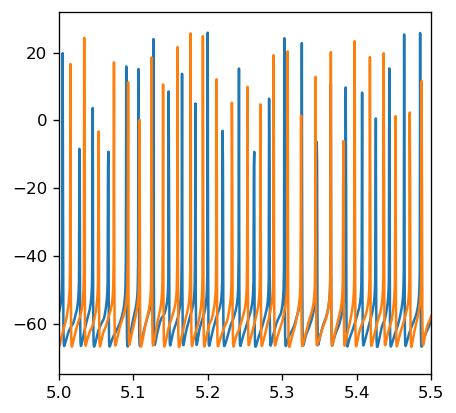

In [309]:
plt.figure(dpi=120, figsize=(4,4))
plt.plot(t, vs[:,:2])
plt.xlim([5, 5.5])
# plt.xlim([0.5, 0.6])
# plt.xlim([0.5, 0.6])
plt.show()

In [306]:
frs = np.array(num_spk)/10
np.std(frs[:80], axis=0)

5.507988374851566

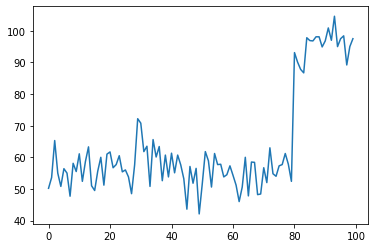

In [307]:
plt.plot(frs)

In [305]:
np.average(num_spk[:80])/10

0.5611375000000001

In [304]:
np.average(num_spk[80:])/1000

0.9561000000000001

## Single variable check

In [279]:
keys = ["v", "h", "i", "n"]
data_single = {}
for k in keys:
    with open("./single_%s.txt"%(k), "r") as fid:
        data_single[k] = [float(x) for x in fid.readline().split(",")[:-1]]
        
dt = 0.01
t_single = np.arange(len(data_single["v"])) * dt

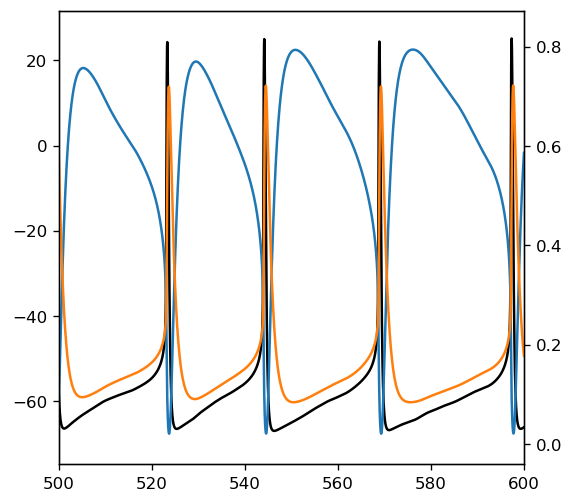

In [280]:
plt.figure(dpi=120, figsize=(5,5))
plt.plot(t_single, data_single["v"], c='k', label="v")
plt.twinx()
plt.plot(t_single, data_single["h"], label="h")
plt.plot(t_single, data_single["n"], label="n")
plt.xlim([500, 600])
plt.show()

In [208]:
with open("./check_i.txt", "r") as fid:
    ic = [float(x) for x in fid.readline().split(",")[:-1]]

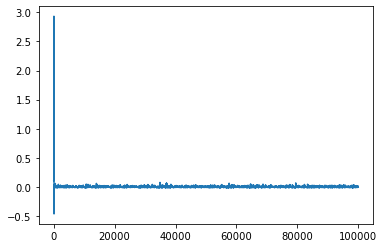

In [209]:
plt.plot(ic)

## 

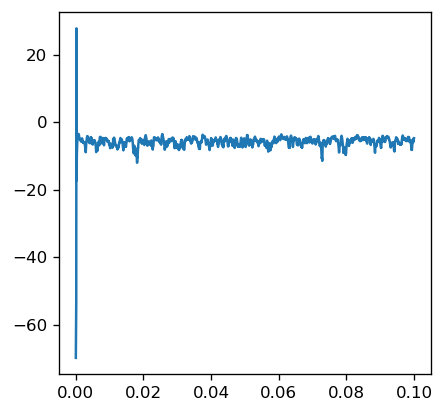

In [207]:
nid = -20

plt.figure(dpi=120, figsize=(4,4))
plt.plot(t0[:nid], v0[:nid])
# plt.xlim([0.00125, 0.00132])
plt.show()

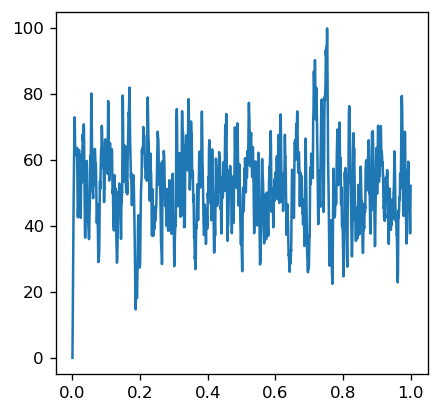

In [188]:
plt.figure(dpi=120, figsize=(4,4))
plt.plot(t, rext[:,53])
plt.show()

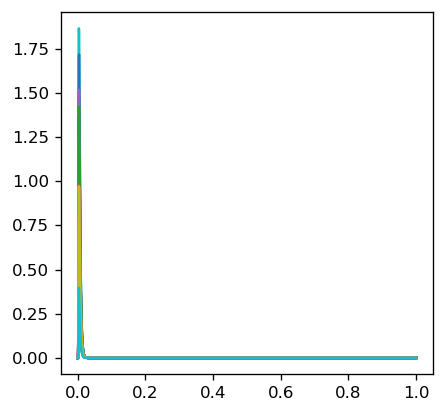

In [189]:
plt.figure(dpi=120, figsize=(4,4))
plt.plot(t, re[:,:50])
plt.show()

In [91]:
def get_chi(vs):
    V = np.average(vs, axis=1)
    sV = np.var(V)
    svi = np.var(V, axis=0)
    print("var tot: %f, var indiv: %f"%(sV, svi * vs.shape[1]))
    return sV / np.average(svi)

In [92]:
print(get_chi(vs[:,:80]), get_chi(vs[:,80:]))

var tot: 0.223923, var indiv: 17.913830
var tot: 0.223924, var indiv: 4.478474
1.0 1.0


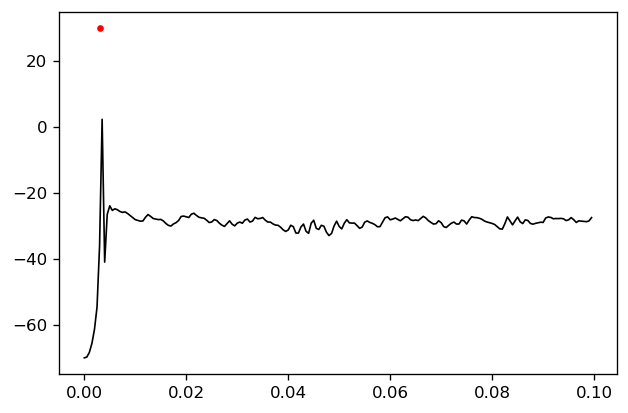

In [76]:
nid = 95
vth = 30
dt = 0.001

plt.figure(dpi=120, figsize=(6, 4))
plt.plot(t, vs[:, nid], c='k', lw=1)
plt.plot(step_spk[nid]*dt/1000, [vth] * len(step_spk[nid]), 'r.')
plt.show()

In [60]:
step_spk[nid]

array([2771], dtype=int32)

In [54]:
step_spk[0]

array([2771], dtype=int32)

In [162]:
with open("./check_n_ext.txt", "r") as fid:
    data = [int(x) for x in fid.readline().split(",")[:-1]]

In [165]:
np.average(data), np.std(data)**2

(6.2306626645116605, 6.168683444505393)

In [ ]:
0.001/